# Zadanie 1 - MLP Clasificator
### Vypracoval: Andrej Petričko, Oleksandr Lytvyn
Zadanie úlohy:
Implementujte a natrénujte MLP vo frameworku Tensorflow a PyTorch (LibTorch) tak,
že bude úspešný (>>lepší ako náhoda) na probléme ručne písaných čísel.

## Importy

In [2]:
import numpy as np
import pandas as pd


import wandb
import matplotlib.pyplot as plt
import seaborn as sn

from collections import Counter


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.compat.v1 as tf






## Načítanie datasetu


In [3]:
train = pd.read_csv("./data/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv("./data/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analýza datasetu

In [3]:
z_train = Counter(train['label'])
z_train

Counter({1: 4684,
         0: 4132,
         4: 4072,
         7: 4401,
         3: 4351,
         5: 3795,
         8: 4063,
         9: 4188,
         2: 4177,
         6: 4137})

/Users/MacBook/Documents/python/nsiete_zadanie1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

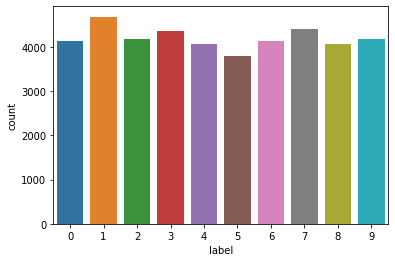

In [4]:
sn.countplot(train['label'])

Z histogramu čísel môžme vidieť, že jednotlivé čísla majú podobne veľké zastúpenie v datasete


In [4]:
print("Max pixel value: ",np.max(train.values[1]))
print("Min pixel value: ",np.min(train.values[1]))

Max pixel value:  255
Min pixel value:  0


V datasete sú hodnoty pixlov od 0 po 255 to by mohlo viesť k explodujúcim gradientom
a teda bude nutné predspracovať dáta aby sa mohol model lepšie trénovať.

## Predspracovanie dát
Rozdelenie dát na pixle a labele.

In [5]:
x_train_np = train.iloc[:,1:].values.astype('float32') # all pixel values
y_train_np = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits


Hodnoty pixelom sú na intervale 0 až 255 a preto bude vhodné ich normalizovať na hodnoty z intervalu 0 až 1.

In [6]:
x_train_np = x_train_np/255.0
print("Max pixel normalized value: ",np.max(x_train_np[0]))
print("Min pixel normalized value: ",np.min(x_train_np[0]))


Max pixel normalized value:  1.0
Min pixel normalized value:  0.0


Transformácia výstupných hodnôt na one hot encoding.

In [7]:
y_train_np_1h = np.eye(10)[y_train_np]
y_train_np_1h


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Rozdelenie na trénovaciu a validačnú sadu, pri použití BinaryCrossEntrophy loss funkcie
sa používa normálne lablovanie z dôvodu implementácie v PyTorch

In [8]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(x_train_np, y_train_np, test_size=1/6, random_state=43)

_, _, y_train_1h, y_valid_1h = \
    train_test_split(x_train_np, y_train_np_1h, test_size=1/6, random_state=43)


print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('Whole dataset size : ', x_train_np.shape)



train image shape :  (35000, 784)
train label shape :  (35000,)
valid image shape :  (7000, 784)
valid label image :  (7000,)
Whole dataset size :  (42000, 784)


Rozdelenie na minibatche

In [9]:
class MNIST(Dataset):

    def __init__(self, X,y,y_1h, mode_1h= False, transform=None):
        self.X=X
        self.y=torch.LongTensor(y)
        self.y_1h=y_1h
        self.transform = transform
        self.mode_1h=mode_1h

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = self.X[index].reshape((28, 28, 1))
        label = self.y[index]
        lable_1h=self.y_1h[index]

        if self.transform is not None:
            image = self.transform(image)

        if self.mode_1h:
            return image,lable_1h
        else:
            return image, label

In [10]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [11]:
train_data = MNIST(X_train,y_train,y_train_1h, transform=transforms.ToTensor())
valid_data = MNIST(X_valid,y_valid,y_valid_1h, transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_data,batch_size=532)
valid_loader = DataLoader(dataset=valid_data,batch_size=532)

In [12]:
dataiter=iter(train_loader)
images, labels = dataiter.next()

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([532, 1, 28, 28])
labels shape on PyTroch :  torch.Size([532])


(-0.5, 151.5, 151.5, -0.5)

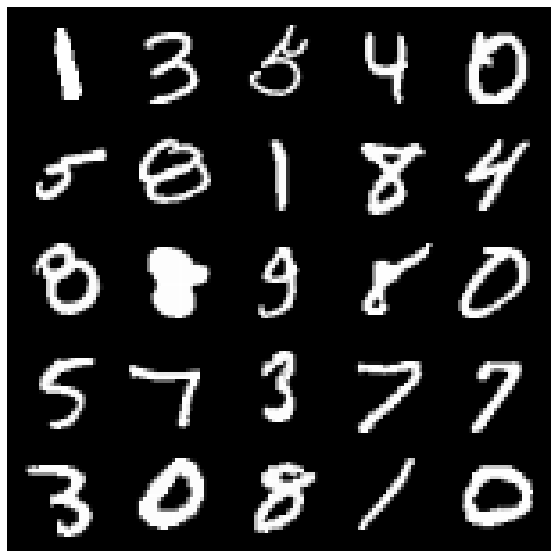

In [15]:
grid = torchvision.utils.make_grid(images[:25], nrow=5)

fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

## PyTorch MLP Clasificator


In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

## WandB inicializácia

In [ ]:
run = wandb.init(project='zadanie1', entity='xpetricko')



model_torch = Model()

learning_rate = 0.001
betas=(0.9, 0.999)

optimizer = torch.optim.Adam(model_torch.parameters(), lr=learning_rate, betas=betas)
loss_fn = nn.CrossEntropyLoss()
#WanDb settings
config = wandb.config
config.learning_rate = learning_rate
config.betas=betas
config.transform = False
config.batch_size=532
wandb.watch(model_torch)


mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 80



#Aby rôzne modely začínaly s rovnakými inicializovanými váhami
torch.manual_seed(10)

for epoch in range(epochs):
    model_torch.train()

    train_losses = []
    valid_losses = []
    for i, (images,labels) in enumerate(train_loader):

        optimizer.zero_grad()

        output = model_torch(images) # (data)
        loss = loss_fn(output,labels) # (Output, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        wandb.log({"train_loss": loss.item()})
        # Some print if wanted

    model_torch.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
                outputs = model_torch(images)
                loss = loss_fn(outputs, labels)

                valid_losses.append(loss.item())
                wandb.log({"valid_loss": loss.item()})

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)



    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    wandb.log({"mean_test_loss": np.mean(train_losses),"mean_valid_loss": np.mean(train_losses)})



    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    wandb.log({"valid_accuracy": accuracy})

    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

run.finish()


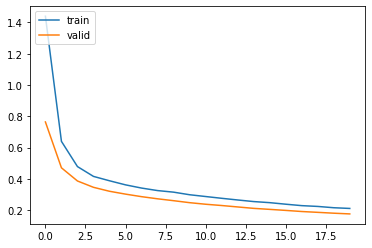

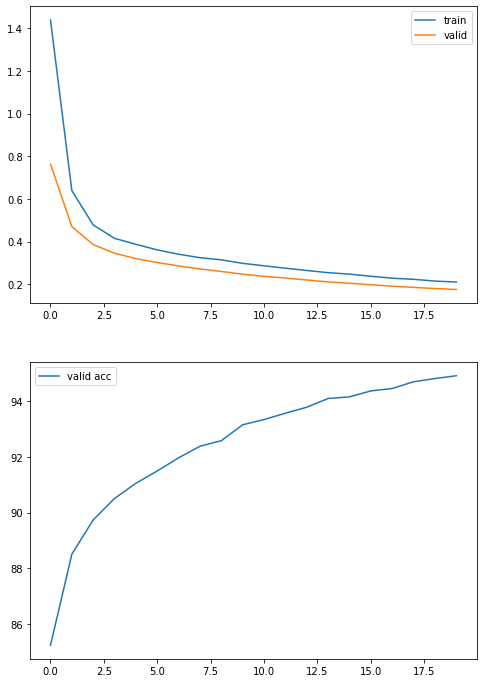

In [56]:
plt.plot(mean_train_losses,label='train')
plt.plot(mean_valid_losses,label='valid')
plt.legend(loc="upper left")
plt.show()

fig, (plot1, plot2) = plt.subplots(nrows=2, ncols=1,figsize=(8,12))
plot1.plot(mean_train_losses, label='train')
plot1.plot(mean_valid_losses, label='valid')
plot1.legend(loc='best')

plot2.plot(valid_acc_list, label='valid acc')
plot2.legend()


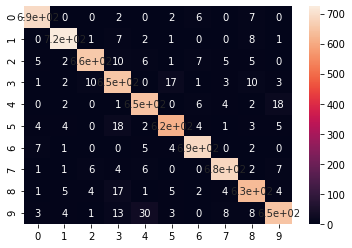

In [23]:
cm = None
with torch.no_grad():
    output = model_torch(torch.Tensor(X_valid))
    _, predicted = torch.max(output.data, 1)


    cm = confusion_matrix(y_valid,predicted)

    sn.heatmap(cm,annot=True)

## Tensorflow MLP Clasificator

In [ ]:
def mlp(x):
    # hidden layer1
    w1 = tf.Variable(tf.random_uniform([784, 256]))
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.matmul(x, w1) + b1
    # hidden layer2
    w2 = tf.Variable(tf.random_uniform([256, 128]))
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    # output layer
    w3 = tf.Variable(tf.random_uniform([128,10]))
    b3 = tf.Variable(tf.zeros([10]))
    logits = tf.matmul(h2, w3) + b3
    
    return logits


In [ ]:
tf.disable_eager_execution()
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

In [ ]:
logits = mlp(x)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                   labels=y))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_op)

In [ ]:
init = tf.global_variables_initializer()

# train parameters
epochs = 15
batch_size = 1000
iteration = len(X_train)//batch_size

train_losses = []
valid_losses = []
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []


with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        avg_loss = 0.
        start = 0
        end = batch_size
        
        for i in range(iteration):
            _, loss = sess.run([train_op, loss_op],
                              feed_dict={x: X_train[start:end],
                                         y: y_train[start:end]})
            start += batch_size
            end += batch_size
            train_losses.append(loss)
        # Validate model    
        preds = tf.nn.softmax(logits)
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y,1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        cur_val_acc = accuracy.eval({x: X_valid, y: y_valid})
        valid_acc_list.append(cur_val_acc)

    plt.plot(mean_train_losses)
    plt.show()
